<a href="https://www.kaggle.com/code/thanhngan123/segnet?scriptVersionId=231363494" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

ver 8 (6)

# **Import lib**

In [1]:
import numpy as np
import os, PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

import cv2, json
from tqdm import tqdm 
import matplotlib.pyplot as plt

import random
from scipy.spatial import ConvexHull

# **Chuẩn bị tập dữ liệu**

In [2]:
# Đọc file Excel
file_path = '/kaggle/input/btxrd-data/classification.xlsx'
df = pd.read_excel(file_path)

# Hiển thị 20 dòng đầu tiên
df.head(20)

,image_id,center,age,gender,neoplasm,tumor_type,img_type,skeletal_type,bones_type,points,area,image_area,tumor_ratio,data_source
0,IMG000001.jpeg,1,48,F,malignant,other mt,frontal,pelvis,hip bone,"[[[2027.9285714285713, 1219.9285714285713], [2...",294967,7701561.0,3.83,train
1,IMG000002.jpeg,1,12,M,malignant,osteosarcoma,frontal,lower limb,tibia,"[[[895.6756756756756, 614.1981981981984], [895...",131041,4972480.0,2.64,train
2,IMG000003.jpeg,1,12,M,malignant,osteosarcoma,lateral,lower limb,tibia,"[[[811.7117117117116, 729.5135135135137], [831...",120650,6900832.0,1.75,train
3,IMG000004.jpeg,1,52,M,malignant,osteosarcoma,frontal,lower limb,foot,"[[[1302.6698113207547, 1734.9056603773583], [1...",91065,7214337.0,1.26,train
4,IMG000005.jpeg,1,52,M,malignant,osteosarcoma,oblique,lower limb,foot,"[[[1294.2446043165467, 1594.1870503597122], [1...",88469,7017152.0,1.26,train
5,IMG000006.jpeg,1,62,M,malignant,osteosarcoma,frontal,lower limb,femur,"[[[591.9130434782609, 1916.3043478260868], [47...",806550,5627824.0,14.33,train
6,IMG000007.jpeg,1,62,M,malignant,osteosarcoma,lateral,lower limb,femur,"[[[868.3636363636363, 420.45454545454544], [92...",592080,5172384.0,11.45,train
7,IMG000008.jpeg,1,6,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[585.0, 904.7058823529412], [577.35294117647...",61063,2650000.0,2.30,train
8,IMG000009.jpeg,1,6,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[671.6216216216216, 1090.9819819819818], [64...",49362,3085000.0,1.60,train
9,IMG000010.jpeg,1,16,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[327.1296296296297, 1343.1604938271603], [36...",130881,4866640.0,2.69,train


In [3]:
image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images"
annotation_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations"

classification_file_path = '/kaggle/input/btxrd-data/classification.xlsx'
train_file_path = '/kaggle/input/btxrd-data/train.xlsx'
val_file_path = '/kaggle/input/btxrd-data/val.xlsx'

In [4]:
tumor_type_column = 'tumor_type'
source_col_name = 'data_source'

try:
    print(f"Đang đọc tệp: {classification_file_path}")
    df = pd.read_excel(classification_file_path)
    print(f"Đã đọc {len(df)} dòng.")

    required_cols = [tumor_type_column, source_col_name]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Lỗi: Tệp '{classification_file_path}' thiếu các cột cần thiết: {missing_cols}. "
                         f"Các cột có sẵn là: {list(df.columns)}. "
                         f"Hãy đảm bảo bạn đang đọc file Excel đã được thêm cột '{source_col_name}'.")

    # Thống kê số lượng theo tumor_type VÀ data_source 
    grouped_counts = df.groupby([tumor_type_column, source_col_name]).size()

    detailed_counts = grouped_counts.unstack(level=source_col_name, fill_value=0)

    if 'train' not in detailed_counts.columns:
        print("Cảnh báo: Không tìm thấy dữ liệu 'train' trong cột data_source. Thêm cột 'train' với giá trị 0.")
        detailed_counts['train'] = 0
    if 'test' not in detailed_counts.columns:
        print("Cảnh báo: Không tìm thấy dữ liệu 'test' trong cột data_source. Thêm cột 'test' với giá trị 0.")
        detailed_counts['test'] = 0

    # Tính cột tổng cộng
    detailed_counts['total'] = detailed_counts['train'] + detailed_counts['test']

    final_columns_order = [col for col in ['test', 'train', 'total'] if col in detailed_counts.columns]
    detailed_counts = detailed_counts[final_columns_order]

    print(detailed_counts.to_string())

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp tại đường dẫn '{classification_file_path}'.")
    print("Vui lòng kiểm tra lại đường dẫn. Nếu bạn đã lưu file vào /kaggle/working/, hãy sử dụng đường dẫn đó.")
except ValueError as e:
    # In lỗi cụ thể về việc thiếu cột
    print(e)
except Exception as e:
    print(f"Đã xảy ra lỗi không xác định khi xử lý tệp: {e}")

Đang đọc tệp: /kaggle/input/btxrd-data/classification.xlsx
Đã đọc 3746 dòng.
data_source               test  train  total
tumor_type                                  
giant cell tumor            20     73     93
multiple osteochondromas    66    197    263
osteochondroma             138    616    754
osteofibroma                14     30     44
osteosarcoma                53    244    297
other bt                    22     93    115
other mt                    11     34     45
simple bone cyst            37    169    206
synovial osteochondroma     13     37     50


# **Tiền xử lý dữ liệu**
Scale factor: 0.1, Target size: 512x512

In [5]:
SCALE_FACTOR = 0.1 # Scale về 10%
TARGET_SIZE = 512

In [6]:
output_dir = "/kaggle/working/btxrd_v2"
output_image_dir = os.path.join(output_dir, "images")
output_anno_dir = os.path.join(output_dir, "Annotations")

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_anno_dir, exist_ok=True)

MAX_VISUALIZATIONS = 5 # Số lượng ảnh tối đa để trực quan hóa
visualized_count = 0

def get_bounding_box(points):
    if not points:
        return None
    points_array = np.array(points)
    xmin = int(np.min(points_array[:, 0]))
    ymin = int(np.min(points_array[:, 1]))
    xmax = int(np.max(points_array[:, 0]))
    ymax = int(np.max(points_array[:, 1]))
    # Đảm bảo tọa độ không âm
    xmin = max(0, xmin)
    ymin = max(0, ymin)
    return (xmin, ymin, xmax, ymax)

try:
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    total_images = len(image_files)
    if total_images == 0:
        print(f"Không tìm thấy file ảnh nào trong: {image_dir}")
        exit()
    print(f"Tìm thấy {total_images} ảnh để xử lý.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy thư mục ảnh: {image_dir}")
    exit()

Tìm thấy 3746 ảnh để xử lý.


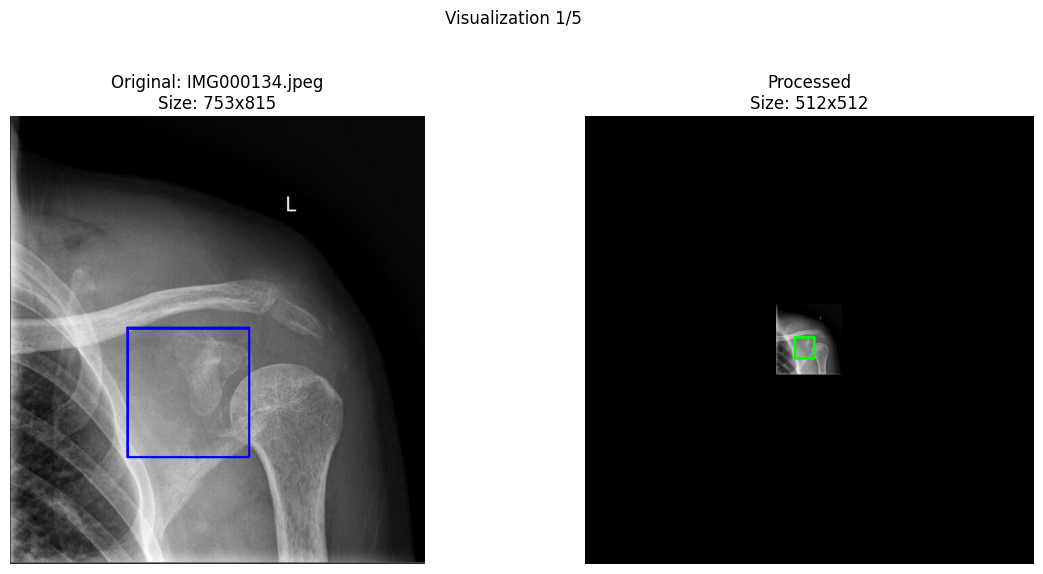

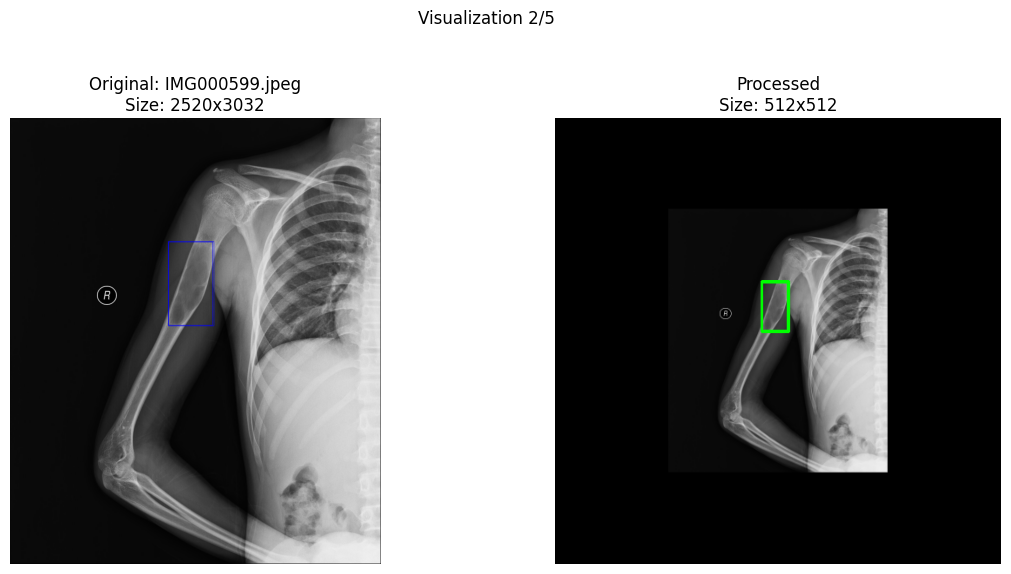

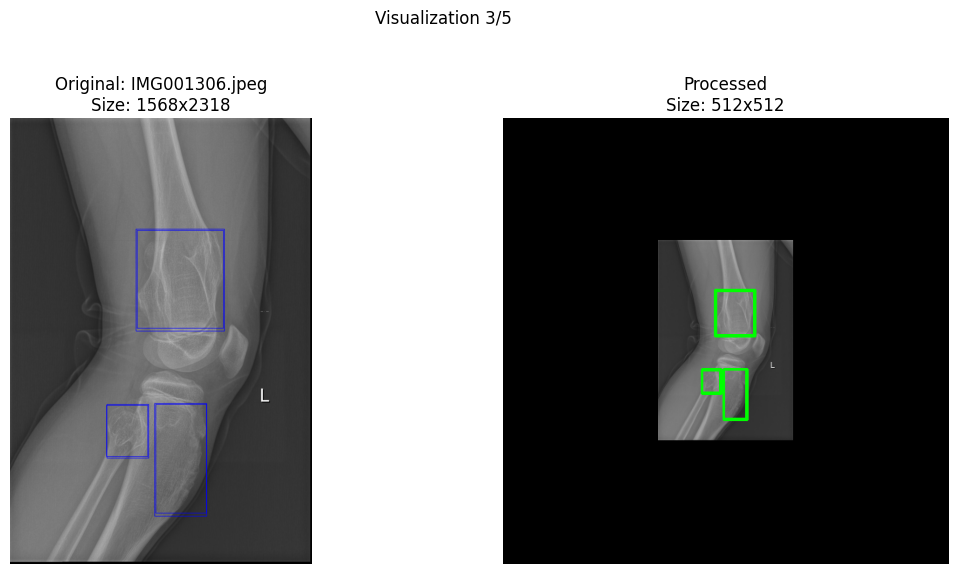

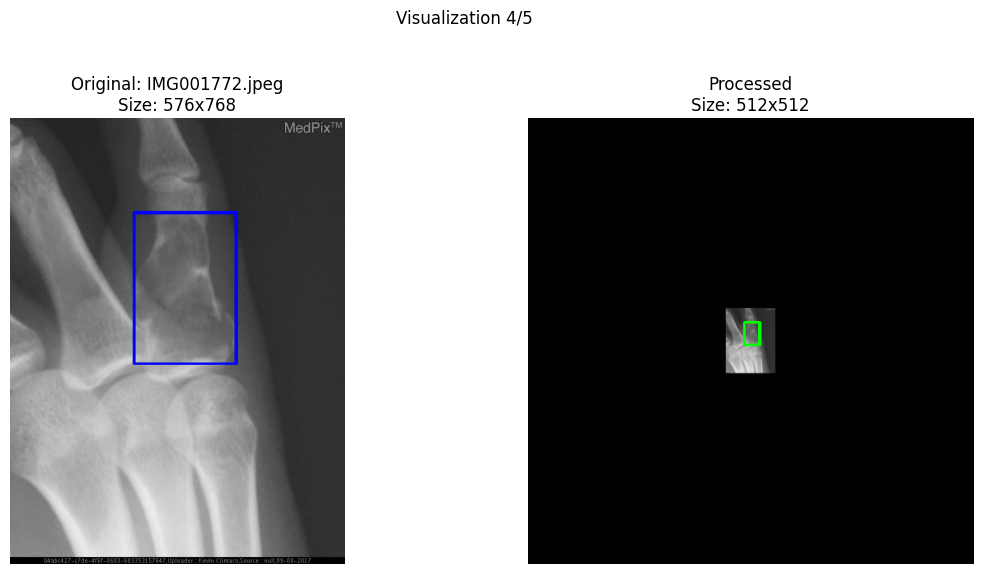

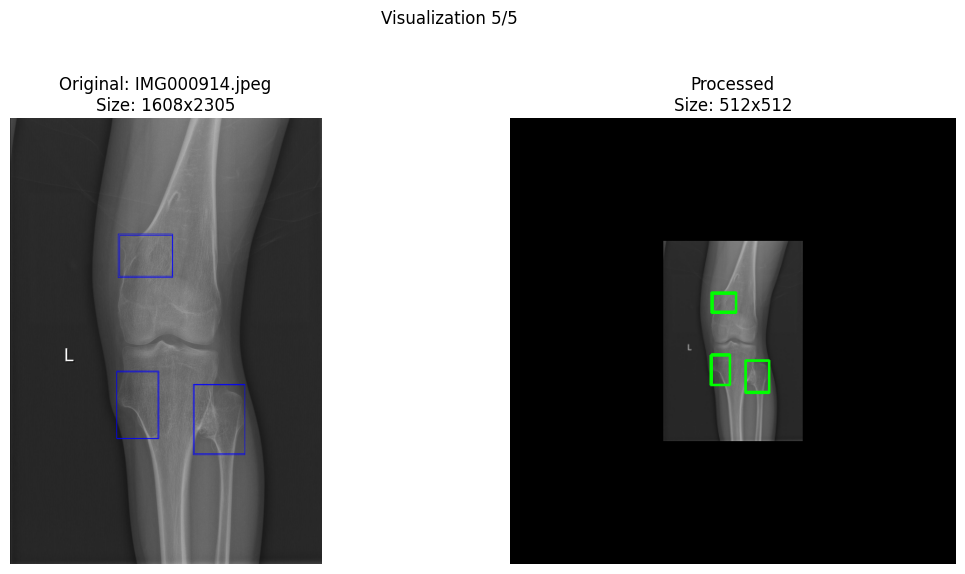

Ảnh và annotation đã xử lý được lưu tại: /kaggle/working/btxrd_v2


In [7]:
for file in image_files:
    img_path = os.path.join(image_dir, file)
    anno_filename = file.rsplit('.', 1)[0] + '.json'
    anno_path = os.path.join(annotation_dir, anno_filename)

    img_orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_orig is None:
        # print(f"Không thể đọc ảnh: {file}") # Có thể bỏ comment nếu muốn thấy lỗi cụ thể trong log tqdm
        continue
    orig_height, orig_width = img_orig.shape[:2]

    # Đọc annotation gốc (nếu có)
    annotation_orig = None
    has_annotation = os.path.exists(anno_path)
    if has_annotation:
        try:
            with open(anno_path, "r", encoding="utf-8") as f:
                annotation_orig = json.load(f)
        except Exception as e:
            # print(f"Lỗi khi đọc annotation {anno_filename}: {e}") # Bỏ comment nếu cần debug
            has_annotation = False

    # Chuẩn bị cho trực quan hóa (NẾU cần)
    img_to_draw_orig = None
    img_to_draw_padded = None
    original_bboxes = []
    transformed_bboxes = []

    should_visualize = has_annotation and (visualized_count < MAX_VISUALIZATIONS)

    if should_visualize:
        img_to_draw_orig = cv2.cvtColor(img_orig, cv2.COLOR_GRAY2BGR)
        if annotation_orig and "shapes" in annotation_orig:
             for shape in annotation_orig["shapes"]:
                if "points" in shape and shape["points"]:
                    bbox = get_bounding_box(shape["points"])
                    if bbox:
                        original_bboxes.append(bbox)
                        cv2.rectangle(img_to_draw_orig, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2) # Red

    # Resize ảnh 
    new_width = max(1, int(orig_width * SCALE_FACTOR))
    new_height = max(1, int(orig_height * SCALE_FACTOR))
    img_resized = cv2.resize(img_orig, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # thêm padding
    pad_h = TARGET_SIZE - new_height
    pad_w = TARGET_SIZE - new_width
    top = max(0, pad_h // 2)
    bottom = max(0, pad_h - top)
    left = max(0, pad_w // 2)
    right = max(0, pad_w - left)
    padded_img = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0) # Black padding

    # Lưu ảnh đã xử lý
    output_img_path = os.path.join(output_image_dir, file)
    try:
        cv2.imwrite(output_img_path, padded_img)
    except Exception as e:
        # print(f"Lỗi khi lưu ảnh {output_img_path}: {e}") # Bỏ comment nếu cần debug
        continue

    # Xử lý và lưu annotation (nếu có)
    if has_annotation and annotation_orig:
        annotation_new = json.loads(json.dumps(annotation_orig)) # Deep copy
        if "shapes" in annotation_new:
            for shape in annotation_new["shapes"]:
                if "points" in shape and shape["points"]:
                    original_points = shape["points"]
                    new_points_transformed = []
                    for x, y in original_points:
                        new_x = (x * SCALE_FACTOR) + left
                        new_y = (y * SCALE_FACTOR) + top
                        new_points_transformed.append([new_x, new_y])
                    shape["points"] = new_points_transformed

                    if should_visualize:
                        new_bbox = get_bounding_box(new_points_transformed)
                        if new_bbox:
                            transformed_bboxes.append(new_bbox)

            annotation_new["imageWidth"] = TARGET_SIZE
            annotation_new["imageHeight"] = TARGET_SIZE

            output_annotation_path = os.path.join(output_anno_dir, anno_filename)
            try:
                with open(output_annotation_path, "w", encoding="utf-8") as f:
                    json.dump(annotation_new, f, indent=4)
            except Exception as e:
                # print(f"Lỗi khi lưu annotation {output_annotation_path}: {e}") # Bỏ comment nếu cần debug
                pass # Tiếp tục xử lý ảnh tiếp theo dù annotation lỗi

            # Trực quan hóa (NẾU cần và đã chuẩn bị)
            if should_visualize and img_to_draw_orig is not None:
                img_to_draw_padded = cv2.cvtColor(padded_img, cv2.COLOR_GRAY2BGR)
                for bbox in transformed_bboxes:
                     cv2.rectangle(img_to_draw_padded, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2) # Green

                # Hiển thị bằng Matplotlib
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                axes[0].imshow(img_to_draw_orig)
                axes[0].set_title(f'Original: {file}\nSize: {orig_width}x{orig_height}')
                axes[0].axis('off')
                axes[1].imshow(img_to_draw_padded)
                axes[1].set_title(f'Processed\nSize: {TARGET_SIZE}x{TARGET_SIZE}')
                axes[1].axis('off')
                plt.suptitle(f"Visualization {visualized_count + 1}/{MAX_VISUALIZATIONS}")
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
                visualized_count += 1

print(f"Ảnh và annotation đã xử lý được lưu tại: {output_dir}")

sau khi xoay ảnh mask có xoay không?

Kiểm tra xoay ảnh và điểm annotation từ JSON:
Thư mục ảnh: /kaggle/working/btxrd_v2/images
Thư mục annotation: /kaggle/working/btxrd_v2/Annotations
Góc xoay kiểm tra: 90 độ

Tìm thấy tổng cộng 3746 ảnh.
Đã chọn ngẫu nhiên 5 ảnh có annotation để hiển thị kiểm tra xoay.

--- Ảnh 1/5: IMG000992.jpeg ---
  Annotation: /kaggle/working/btxrd_v2/Annotations/IMG000992.json


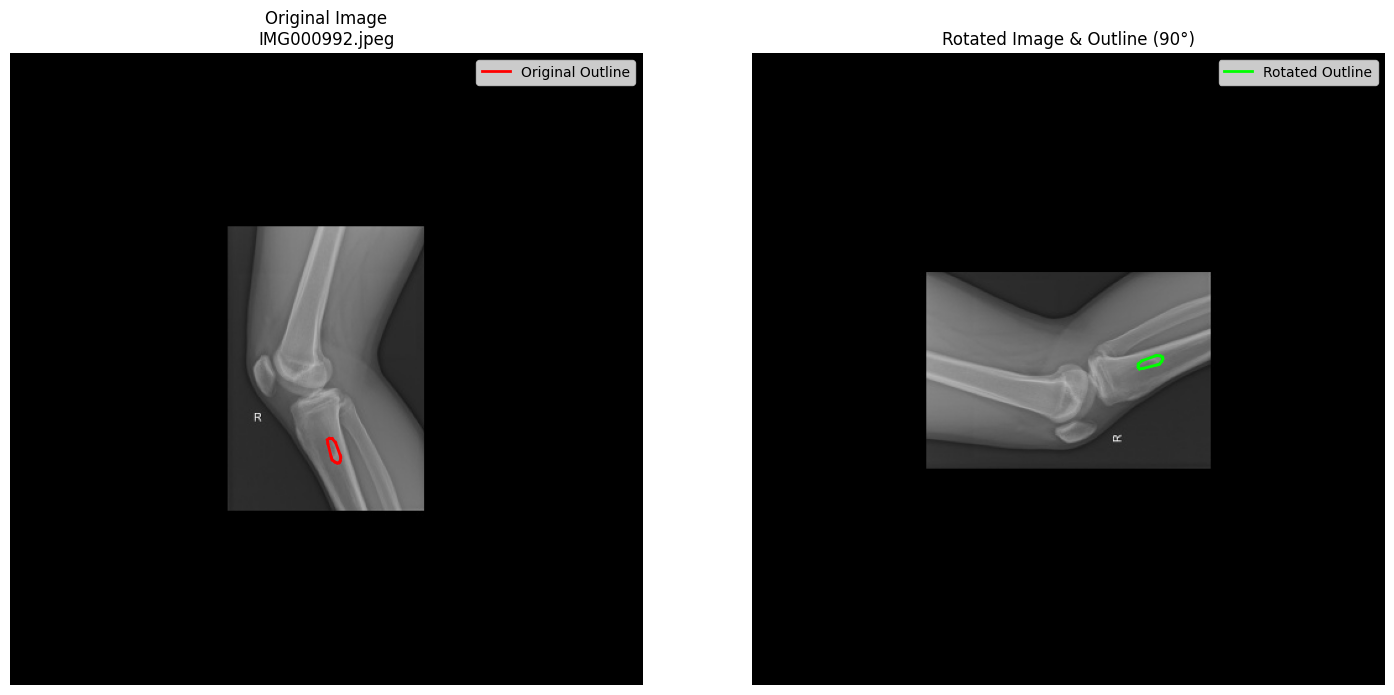


--- Ảnh 2/5: IMG000230.jpeg ---
  Annotation: /kaggle/working/btxrd_v2/Annotations/IMG000230.json


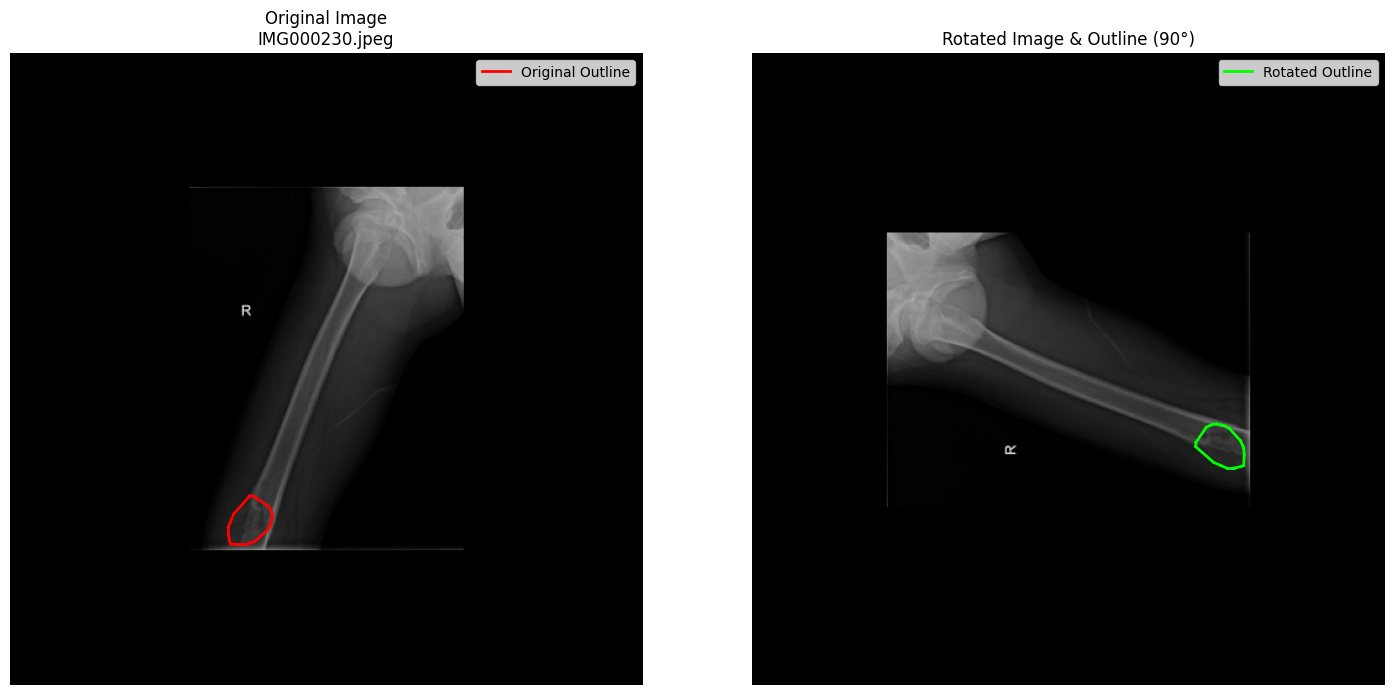


--- Ảnh 3/5: IMG001595.jpeg ---
  Annotation: /kaggle/working/btxrd_v2/Annotations/IMG001595.json


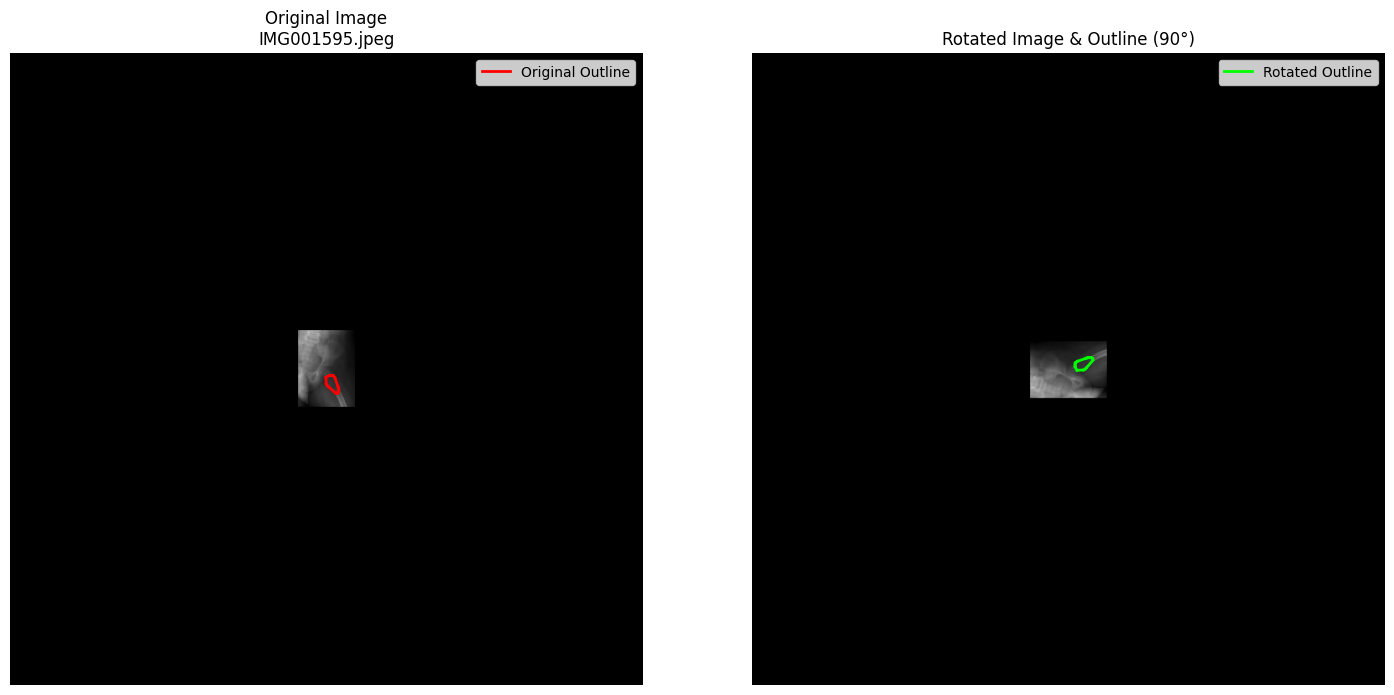


--- Ảnh 4/5: IMG000975.jpeg ---
  Annotation: /kaggle/working/btxrd_v2/Annotations/IMG000975.json


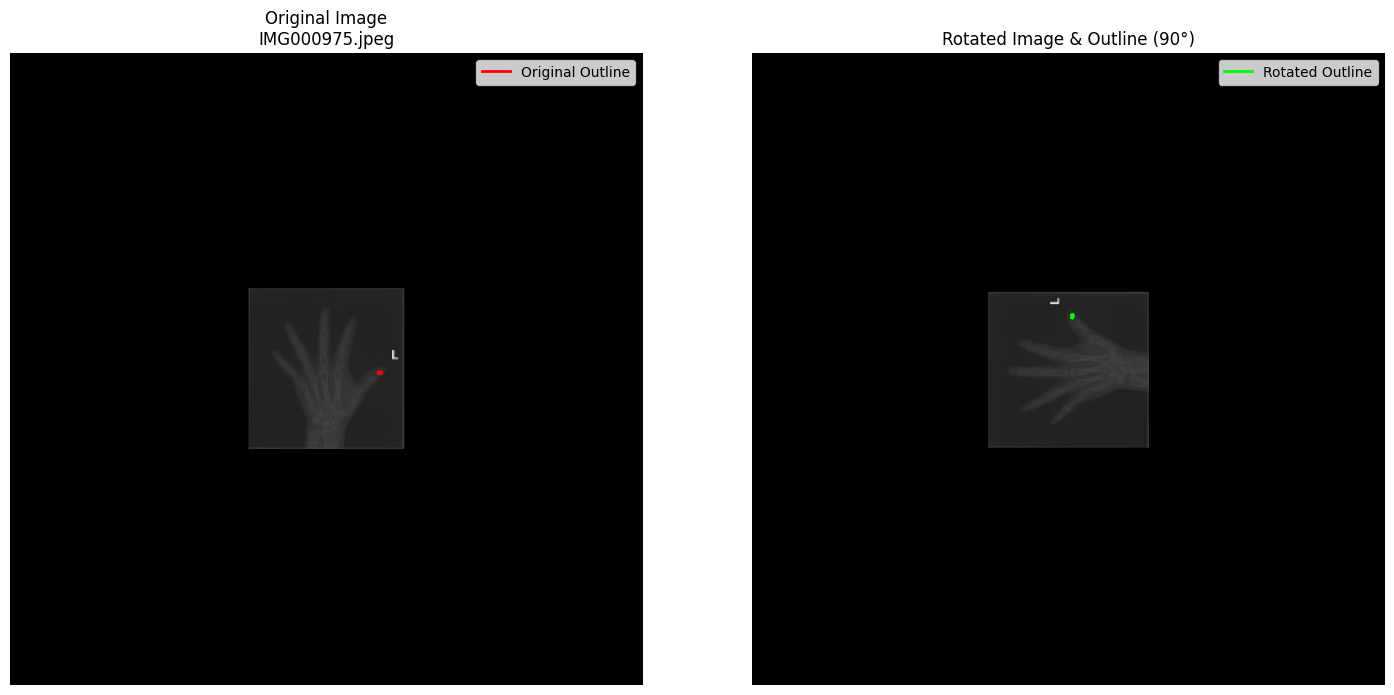


--- Ảnh 5/5: IMG000965.jpeg ---
  Annotation: /kaggle/working/btxrd_v2/Annotations/IMG000965.json


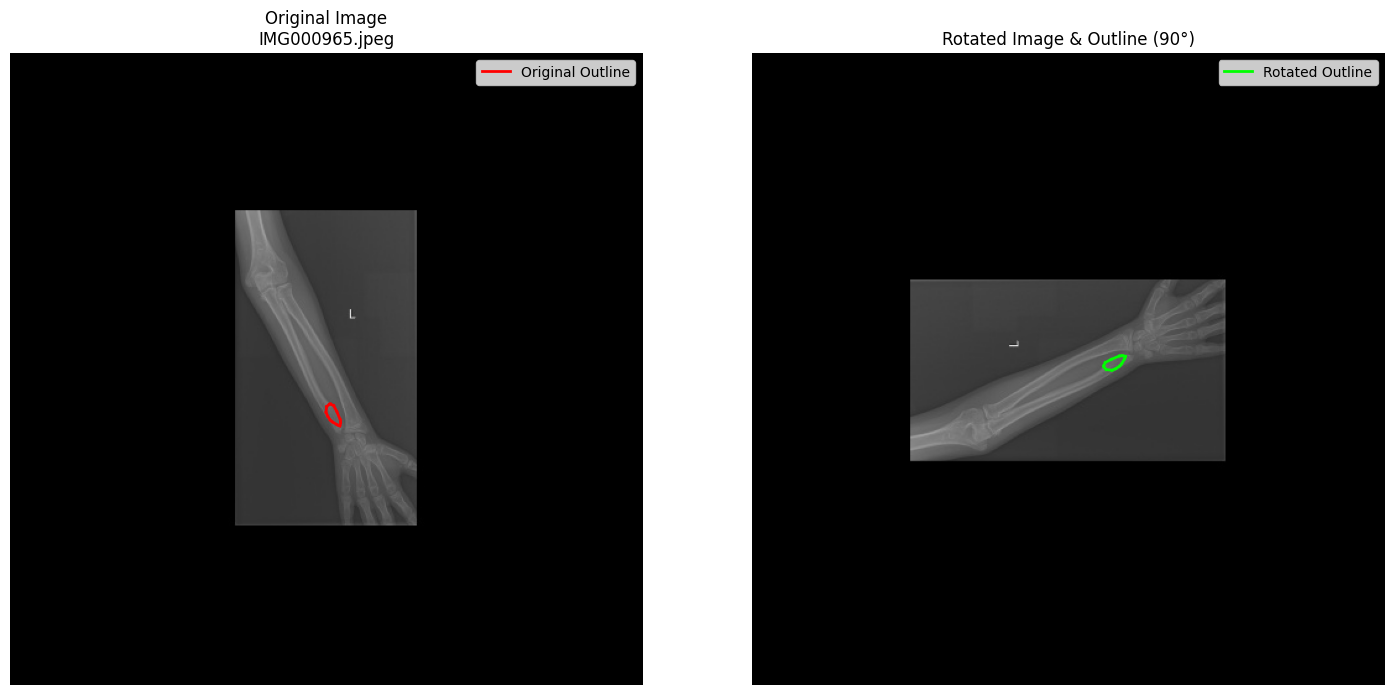

In [11]:
# --- Configuration ---
processed_image_dir = "/kaggle/working/btxrd_v2/images" # Thư mục ảnh đã xử lý
annotation_dir = "/kaggle/working/btxrd_v2/Annotations" # Thư mục chứa file JSON

rotation_angle = 90  # Góc xoay (độ). Dương là ngược chiều kim đồng hồ.
num_visualizations = 5 # Số lượng ảnh muốn kiểm tra
point_color_orig = 'red'  # Màu cho điểm gốc
point_color_rotated = 'lime' # Màu cho điểm đã xoay (lime dễ nhìn trên nền đen/xám)
point_size = 15 # Kích thước điểm vẽ

print(f"Kiểm tra xoay ảnh và điểm annotation từ JSON:")
print(f"Thư mục ảnh: {processed_image_dir}")
print(f"Thư mục annotation: {annotation_dir}")
print(f"Góc xoay kiểm tra: {rotation_angle} độ")

# --- Lấy danh sách file ảnh ---
try:
    all_image_files = [f for f in os.listdir(processed_image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not all_image_files:
        print(f"Lỗi: Không tìm thấy file ảnh nào trong {processed_image_dir}")
        exit()
    print(f"\nTìm thấy tổng cộng {len(all_image_files)} ảnh.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy thư mục ảnh: {processed_image_dir}")
    exit()
except Exception as e:
    print(f"Lỗi khi truy cập thư mục ảnh: {e}")
    exit()

# --- Chọn ngẫu nhiên ảnh để kiểm tra ---
# Lọc ra những ảnh có file annotation tương ứng tồn tại
files_with_annotations = []
for img_file in all_image_files:
    json_filename = os.path.splitext(img_file)[0] + '.json'
    json_path = os.path.join(annotation_dir, json_filename)
    if os.path.exists(json_path):
        files_with_annotations.append(img_file)

if not files_with_annotations:
    print("Lỗi: Không tìm thấy cặp ảnh/annotation nào để kiểm tra.")
    exit()

num_to_select = min(num_visualizations, len(files_with_annotations))
if num_to_select < num_visualizations:
     print(f"Cảnh báo: Chỉ tìm thấy {num_to_select} ảnh có annotation, sẽ hiển thị những ảnh này.")

selected_files = random.sample(files_with_annotations, num_to_select)
print(f"Đã chọn ngẫu nhiên {num_to_select} ảnh có annotation để hiển thị kiểm tra xoay.")

# --- Vòng lặp kiểm tra và hiển thị ---
for i, filename in enumerate(selected_files):
    image_path = os.path.join(processed_image_dir, filename)
    json_filename = os.path.splitext(filename)[0] + '.json'
    json_path = os.path.join(annotation_dir, json_filename)

    print(f"\n--- Ảnh {i+1}/{num_to_select}: {filename} ---")
    print(f"  Annotation: {json_path}")

    # --- Đọc ảnh ---
    img = cv2.imread(image_path, cv2.IMREAD_COLOR) # Đọc màu để vẽ
    if img is None:
        print(f"  Lỗi: Không thể đọc ảnh {image_path}")
        continue
    h_img, w_img = img.shape[:2]

    # --- Đọc annotation JSON ---
    annotation = None
    original_points_flat = [] # Danh sách [[x1,y1], [x2,y2], ...]
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            annotation = json.load(f)
        # Trích xuất tất cả các điểm từ tất cả các shape
        if annotation and "shapes" in annotation:
            for shape in annotation["shapes"]:
                if "points" in shape and shape["points"]:
                    original_points_flat.extend(shape["points"])
        if not original_points_flat:
            print("  Cảnh báo: Không tìm thấy 'points' hợp lệ trong file JSON. Bỏ qua hiển thị điểm.")

    except FileNotFoundError:
         print(f"  Lỗi: Không tìm thấy file annotation {json_path}")
         continue # Bỏ qua nếu không có file json
    except Exception as e:
        print(f"  Lỗi khi đọc hoặc phân tích JSON {json_path}: {e}")
        continue # Bỏ qua nếu lỗi đọc json

    # --- Thực hiện phép xoay ---
    center = (w_img // 2, h_img // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Xoay ảnh
    img_rotated = cv2.warpAffine(img, rotation_matrix, (w_img, h_img),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=(0, 0, 0))

    # --- Biến đổi tọa độ các điểm annotation ---
    transformed_points_flat = []
    if original_points_flat:
        # Chuyển điểm gốc sang dạng cột [[x],[y],[1]] để nhân ma trận mở rộng
        # Hoặc áp dụng công thức trực tiếp:
        # x' = M[0,0]*x + M[0,1]*y + M[0,2]
        # y' = M[1,0]*x + M[1,1]*y + M[1,2]
        for x, y in original_points_flat:
            new_x = rotation_matrix[0, 0] * x + rotation_matrix[0, 1] * y + rotation_matrix[0, 2]
            new_y = rotation_matrix[1, 0] * x + rotation_matrix[1, 1] * y + rotation_matrix[1, 2]
            transformed_points_flat.append([new_x, new_y])

    # --- Hiển thị kết quả ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 7)) # 1 hàng, 2 cột
    
    # === Phần vẽ cho ảnh gốc ===
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Original Image\n{filename}")
    axes[0].axis('off')
    if annotation and "shapes" in annotation:
        plotted_orig = False
        for shape in annotation["shapes"]:
            if "points" in shape and len(shape["points"]) >= 3: # Cần ít nhất 3 điểm để tạo Convex Hull
                points_orig_np = np.array(shape["points"])
                try:
                    hull = ConvexHull(points_orig_np)
                    # Vẽ các cạnh của Convex Hull
                    for simplex in hull.simplices:
                        axes[0].plot(points_orig_np[simplex, 0], points_orig_np[simplex, 1],
                                     color=point_color_orig, linewidth=2,
                                     label='Original Outline' if not plotted_orig else "")
                        plotted_orig = True # Đảm bảo label chỉ được thêm một lần cho ảnh đầu tiên
                except Exception as e:
                    print(f"  Lỗi khi tính Convex Hull cho ảnh gốc shape: {e}")
                    # Dự phòng: Vẽ các điểm nếu không tính được hull
                    axes[0].scatter(points_orig_np[:, 0], points_orig_np[:, 1], color=point_color_orig, s=5, label='Original Points (Hull Error)' if not plotted_orig else "")
                    plotted_orig = True
    
        if plotted_orig:
            axes[0].legend(loc='upper right')
    
    # === Phần vẽ cho ảnh đã xoay ===
    axes[1].imshow(cv2.cvtColor(img_rotated, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Rotated Image & Outline ({rotation_angle}°)")
    axes[1].axis('off')
    if annotation and "shapes" in annotation:
        plotted_rotated = False
        for shape_index, shape in enumerate(annotation["shapes"]):
             if "points" in shape and len(shape["points"]) >= 3: # Cần ít nhất 3 điểm
                original_points_shape = shape["points"]
                transformed_points_shape = []
                # Áp dụng lại phép biến đổi xoay cho điểm của shape này
                for x, y in original_points_shape:
                    new_x = rotation_matrix[0, 0] * x + rotation_matrix[0, 1] * y + rotation_matrix[0, 2]
                    new_y = rotation_matrix[1, 0] * x + rotation_matrix[1, 1] * y + rotation_matrix[1, 2]
                    transformed_points_shape.append([new_x, new_y])
    
                if transformed_points_shape:
                    points_transformed_np = np.array(transformed_points_shape)
                    try:
                        # Kiểm tra lại số điểm vì phép biến đổi có thể làm một số điểm trùng nhau
                        if len(points_transformed_np) >= 3:
                             hull_rotated = ConvexHull(points_transformed_np)
                             # Vẽ các cạnh của Convex Hull đã xoay
                             for simplex in hull_rotated.simplices:
                                 axes[1].plot(points_transformed_np[simplex, 0], points_transformed_np[simplex, 1],
                                              color=point_color_rotated, linewidth=2,
                                              label='Rotated Outline' if not plotted_rotated else "")
                                 plotted_rotated = True
                        elif len(points_transformed_np) > 0 : # Nếu ít hơn 3 điểm, vẽ điểm rời rạc
                            axes[1].scatter(points_transformed_np[:, 0], points_transformed_np[:, 1], color=point_color_rotated, s=5, label='Rotated Points (<3)' if not plotted_rotated else "")
                            plotted_rotated = True
    
                    except Exception as e:
                        print(f"  Lỗi khi tính Convex Hull cho ảnh xoay shape: {e}")
                        # Dự phòng: Vẽ các điểm nếu không tính được hull
                        if len(points_transformed_np) > 0:
                             axes[1].scatter(points_transformed_np[:, 0], points_transformed_np[:, 1], color=point_color_rotated, s=5, label='Rotated Points (Hull Error)' if not plotted_rotated else "")
                             plotted_rotated = True
    
        if plotted_rotated:
            axes[1].legend(loc='upper right')
    
    
    plt.tight_layout()
    plt.show()

Loading and preparing data...
Found 3746 images in /kaggle/working/btxrd_v2/images
Successfully loaded 3746 image/mask pairs.
Data loaded: x_data shape=(3746, 256, 256, 1), y_data_reshaped shape=(3746, 65536, 2)
Splitting data into training and validation sets...
Train set: 2996 samples
Validation set: 750 samples
Building SegNet model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "SegNet_Tumor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 256)         │           1,0

 Total params: 29,457,866 (112.37 MB)

 Trainable params: 29,441,990 (112.31 MB)

 Non-trainable params: 15,876 (62.02 KB)

Compiling model...
Starting training...
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 120s 235ms/step - accuracy: 0.9837 - loss: 0.1658 - val_accuracy: 0.9986 - val_loss: 0.2182
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - accuracy: 0.9986 - loss: 0.1201 - val_accuracy: 0.9976 - val_loss: 0.1270
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 180ms/step - accuracy: 0.9987 - loss: 0.1123 - val_accuracy: 0.9984 - val_loss: 0.1154
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - accuracy: 0.9987 - loss: 0.1053 - val_accuracy: 0.9985 - val_loss: 0.1001
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - accuracy: 0.9987 - loss: 0.0988 - val_accuracy: 0.9986 - val_loss: 0.0938
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - accuracy: 0.9987 - loss: 0.0929 - val_accuracy: 0.9985 - val_loss: 0.0913
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 68s 181ms/step - accuracy: 0.9987 - loss: 0.0875 - val_accuracy: 0.9981 - val_loss: 0.0923
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 68

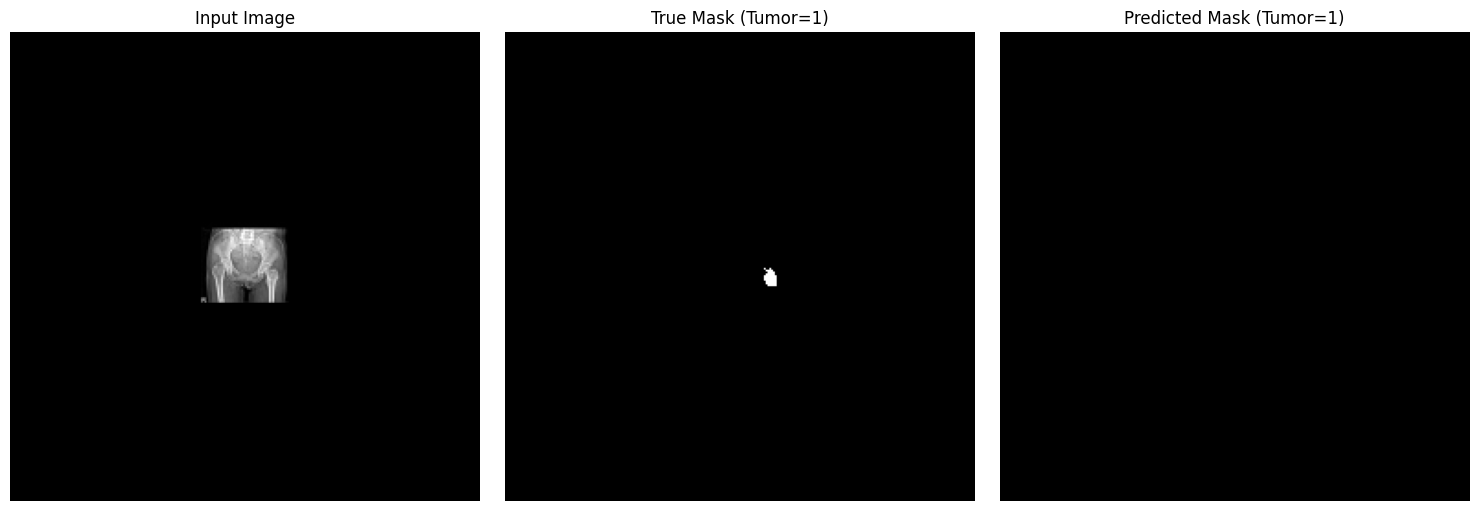

Done.


In [12]:
# chạy theo nhduong dùng dataset btxrd
import cv2
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize # Hoặc dùng cv2.resize
from skimage.io import imread # Hoặc dùng cv2.imread
import time
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, MaxPooling2D,
    UpSampling2D, Reshape, Permute
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split # Để chia dữ liệu

# --- Configuration ---
# ===> THAY ĐỔI ĐƯỜNG DẪN Ở ĐÂY <===
PROCESSED_IMAGE_DIR = "/kaggle/working/btxrd_v2/images" # Thư mục ảnh đã xử lý
PROCESSED_ANNO_DIR = "/kaggle/working/btxrd_v2/Annotations" # Thư mục chứa file JSON
# ==================================

# Model Parameters
N_CLASSES = 2  # 0: background, 1: tumor
KERNEL = 3
MODEL_IMG_H = 256 # Kích thước ảnh đưa vào model
MODEL_IMG_W = 256

# Training Parameters
LR = 0.0001
BATCH_SIZE = 8
EPOCHS = 20 # Tăng số epochs nếu cần

# --- Data Preparation Functions ---

def create_binary_mask_from_json(annotation_path, img_height, img_width):
    """Đọc file JSON và tạo mask nhị phân (0: background, 1: tumor)."""
    mask = np.zeros((img_height, img_width), dtype=np.uint8)
    try:
        with open(annotation_path, "r", encoding="utf-8") as f:
            annotation = json.load(f)

        if "shapes" in annotation:
            for shape in annotation["shapes"]:
                 # Quan trọng: Kiểm tra label nếu cần, ví dụ:
                 # if "points" in shape and shape.get("label", "").lower() == 'tumor':
                 if "points" in shape: # Giả sử mọi shape trong file là tumor
                    points = np.array(shape["points"], dtype=np.int32)
                    cv2.fillPoly(mask, [points], 1)
        return mask
    except FileNotFoundError:
        # print(f"Warning: Annotation file not found: {annotation_path}") # Bỏ comment nếu muốn thấy cảnh báo
        return mask
    except Exception as e:
        print(f"Error reading or processing annotation {annotation_path}: {e}")
        return mask

def one_hot_encode_mask(mask, n_classes, img_h, img_w):
    """Chuyển mask nhị phân (H, W) thành one-hot (H, W, C)."""
    one_hot_mask = np.zeros((img_h, img_w, n_classes), dtype=np.uint8)
    for i in range(n_classes):
        one_hot_mask[:, :, i] = (mask == i).astype(np.uint8)
    return one_hot_mask

def load_and_prepare_data(image_dir, anno_dir, target_h, target_w, n_classes):
    """Load ảnh đã xử lý, tạo mask từ JSON, resize và one-hot encode."""
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Found {len(image_files)} images in {image_dir}")

    data_x_list = []
    data_y_list = []

    for filename in image_files:
        img_path = os.path.join(image_dir, filename)
        anno_filename = os.path.splitext(filename)[0] + '.json'
        anno_path = os.path.join(anno_dir, anno_filename)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            # print(f"Warning: Could not read image {img_path}")
            continue

        orig_processed_h, orig_processed_w = img.shape
        img_resized = cv2.resize(img, (target_w, target_h), interpolation=cv2.INTER_AREA)
        img_normalized = (img_resized / 255.0).astype(np.float32)
        img_final = np.expand_dims(img_normalized, axis=-1)

        binary_mask_orig_size = create_binary_mask_from_json(anno_path, orig_processed_h, orig_processed_w)
        binary_mask_resized = cv2.resize(binary_mask_orig_size, (target_w, target_h), interpolation=cv2.INTER_NEAREST)
        one_hot_mask = one_hot_encode_mask(binary_mask_resized, n_classes, target_h, target_w)

        data_x_list.append(img_final)
        data_y_list.append(one_hot_mask)

    print(f"Successfully loaded {len(data_x_list)} image/mask pairs.")
    if not data_x_list:
        raise ValueError("No data loaded. Check paths and file existence.")

    data_x = np.array(data_x_list)
    data_y = np.array(data_y_list)
    data_y_reshaped = data_y.reshape((-1, target_h * target_w, n_classes))

    return data_x, data_y_reshaped, data_y

# --- Load Data ---
print("Loading and preparing data...")
x_data, y_data_reshaped, y_data_orig_shape = load_and_prepare_data(
    PROCESSED_IMAGE_DIR, PROCESSED_ANNO_DIR, MODEL_IMG_H, MODEL_IMG_W, N_CLASSES
)
print(f"Data loaded: x_data shape={x_data.shape}, y_data_reshaped shape={y_data_reshaped.shape}")

# --- Train/Validation Split ---
print("Splitting data into training and validation sets...")
x_train, x_val, y_train, y_val, y_train_orig, y_val_orig = train_test_split(
    x_data, y_data_reshaped, y_data_orig_shape, test_size=0.2, random_state=42
)
print(f"Train set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")


# --- Build SegNet Model ---
def build_segnet(input_shape, n_classes, kernel=3):
    """Xây dựng kiến trúc SegNet."""
    encoding_layers = [
        Conv2D(64, (kernel, kernel), padding='same', input_shape=input_shape),
        BatchNormalization(), Activation('relu'),
        Conv2D(64, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(),

        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        Conv2D(128, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(),

        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(),

        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(),

        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'),
        BatchNormalization(), Activation('relu'),
        MaxPooling2D(),
    ]

    decoding_layers = [
        UpSampling2D(),
        Conv2D(512, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),

        UpSampling2D(),
        Conv2D(512, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),
        Conv2D(512, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),

        UpSampling2D(),
        Conv2D(256, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),
        Conv2D(256, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),
        Conv2D(128, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),

        UpSampling2D(),
        Conv2D(128, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),
        Conv2D(64, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),

        UpSampling2D(),
        Conv2D(64, (kernel, kernel), padding='same'), BatchNormalization(), Activation('relu'),
        Conv2D(n_classes, (1, 1), padding='valid'),
        BatchNormalization(),
    ]

    segnet_model = models.Sequential(name="SegNet_Tumor")
    for layer in encoding_layers: segnet_model.add(layer)
    for layer in decoding_layers: segnet_model.add(layer)

    segnet_model.add(Reshape((n_classes, input_shape[0] * input_shape[1])))
    segnet_model.add(Permute((2, 1)))
    segnet_model.add(Activation('softmax'))

    return segnet_model

print("Building SegNet model...")
input_shape = (MODEL_IMG_H, MODEL_IMG_W, 1)
model = build_segnet(input_shape, N_CLASSES, KERNEL)
model.summary()

# --- Compile Model ---
print("Compiling model...")
optimizer = Adam(learning_rate=LR)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

# --- Train Model ---
print("Starting training...")
start_time = time.time()

history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    verbose=1)

training_time = time.time() - start_time
print(f'> Training time: {training_time:.2f}s')

# --- Evaluate Model ---
print("Evaluating model on validation set...")
score = model.evaluate(x_val, y_val, verbose=0)
print(f'Validation loss: {score[0]:.4f}')
print(f'Validation accuracy: {score[1]:.4f}')

# --- Visualize Prediction ---
print("Visualizing a random validation sample prediction...")
random_index = np.random.randint(0, len(x_val))
input_image = x_val[random_index]
true_mask_one_hot = y_val_orig[random_index]

prediction_reshaped = model.predict(np.expand_dims(input_image, axis=0))
prediction = prediction_reshaped.reshape((MODEL_IMG_H, MODEL_IMG_W, N_CLASSES))
predicted_mask = np.argmax(prediction, axis=-1)
true_mask = np.argmax(true_mask_one_hot, axis=-1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image[:, :, 0], cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='gray')
plt.title('True Mask (Tumor=1)')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask (Tumor=1)')
plt.axis('off')
plt.tight_layout()
plt.show()

print("Done.")

tới đây chạy được



# ****

xóa từ đây

In [30]:
from keras import models
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Reshape, Permute, Dropout, Flatten, Dense
from keras.optimizers import Adam
import os, numpy as np, matplotlib.pyplot as plt, json, cv2

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import random, shutil

import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from collections import defaultdict

# **1) Chuẩn hóa dữ liệu**

Dataset btxrd-v2
- Giảm kích thước ảnh: scale = 0.5
- Chuẩn hóa ảnh thành hình vuông 2440x2440
- Cập nhật lại points

In [23]:
image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images" 

# Biến lưu kích thước min & max
min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

# Lặp qua tất cả ảnh
for file in os.listdir(image_dir):
    if file.endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(os.path.join(image_dir, file))
        h, w, _ = img.shape  # Lấy chiều cao & chiều rộng

        # Cập nhật kích thước nhỏ nhất
        min_width, min_height = min(min_width, w), min(min_height, h)

        # Cập nhật kích thước lớn nhất
        max_width, max_height = max(max_width, w), max(max_height, h)

print(f"Kích thước nhỏ nhất: {min_width} x {min_height}")
print(f"Kích thước lớn nhất: {max_width} x {max_height}")

Kích thước nhỏ nhất: 153 x 311
Kích thước lớn nhất: 3594 x 4881


In [24]:
from tqdm import tqdm

image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images"
annotation_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations"

output_dir = "/kaggle/working/btxrd-data2"
output_image_dir = os.path.join(output_dir, "images")
output_anno_dir = os.path.join(output_dir, "Annotations")

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_anno_dir, exist_ok=True)

SCALE_FACTOR = 0.2
TARGET_SIZE = 976

# Lấy danh sách file ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Xử lý từng ảnh
for file in tqdm(image_files, desc="Processing images & annotations"):
    img_path = os.path.join(image_dir, file)
    anno_path = os.path.join(annotation_dir, file.rsplit('.', 1)[0] + '.json')

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale
    if img is None:
        print(f"⚠ Không thể đọc ảnh: {file}")
        continue

    orig_height, orig_width = img.shape[:2]

    # Resize ảnh
    new_width = int(orig_width * SCALE_FACTOR)
    new_height = int(orig_height * SCALE_FACTOR)
    img_resized = cv2.resize(img, (new_width, new_height))

    # Tính toán padding
    top = (TARGET_SIZE - new_height) // 2
    bottom = TARGET_SIZE - new_height - top
    left = (TARGET_SIZE - new_width) // 2
    right = TARGET_SIZE - new_width - left

    # Thêm padding vào ảnh
    padded_img = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Lưu ảnh sau khi scale & padding
    output_img_path = os.path.join(output_image_dir, file)
    cv2.imwrite(output_img_path, padded_img)

    # Nếu có annotation thì cập nhật và lưu lại
    if os.path.exists(anno_path):
        with open(anno_path, "r", encoding="utf-8") as f:
            annotation = json.load(f)

        # Cập nhật annotation (scale & padding)
        for shape in annotation["shapes"]:
            new_points = []
            for x, y in shape["points"]:
                # Scale tọa độ
                x = x * SCALE_FACTOR
                y = y * SCALE_FACTOR
                # Padding tọa độ
                x = x + left
                y = y + top
                new_points.append([x, y])

            shape["points"] = new_points  # Cập nhật điểm mới

        # Cập nhật kích thước ảnh trong annotation
        annotation["imageWidth"] = TARGET_SIZE
        annotation["imageHeight"] = TARGET_SIZE

        # Lưu annotation mới
        output_annotation_path = os.path.join(output_anno_dir, file.rsplit('.', 1)[0] + '.json')
        with open(output_annotation_path, "w", encoding="utf-8") as f:
            json.dump(annotation, f, indent=4)

print(f"\nHoàn thành! Ảnh và annotation đã lưu tại: {output_dir}")


Processing images & annotations: 100%|██████████| 3746/3746 [00:57<00:00, 65.31it/s]


Hoàn thành! Ảnh và annotation đã lưu tại: /kaggle/working/btxrd-data2


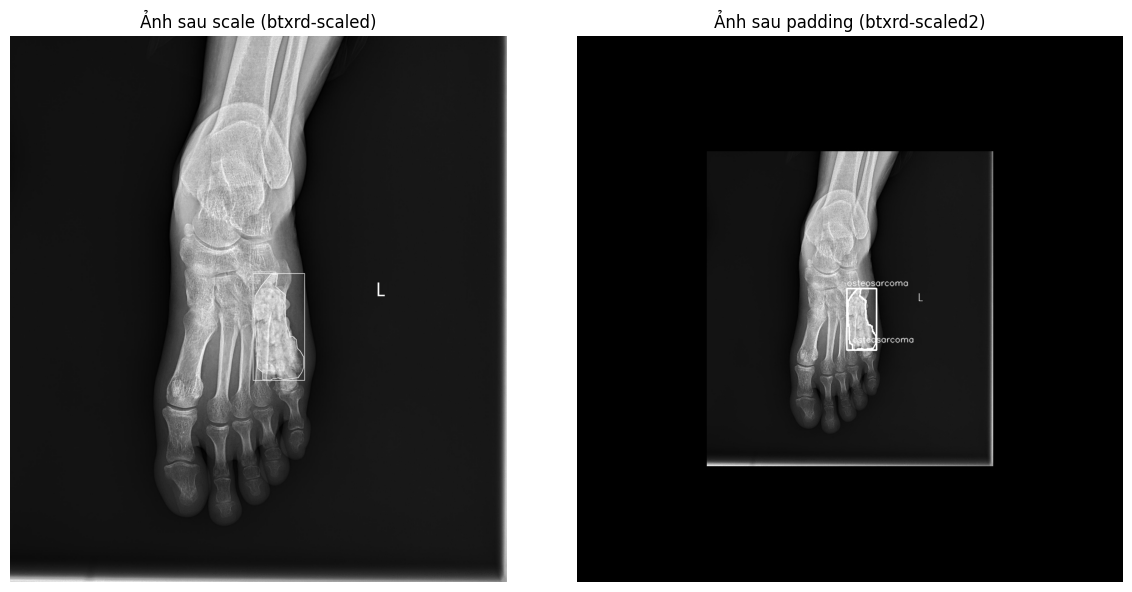


Hoàn thành kiểm tra ảnh!


In [27]:
image_dirs = ["/kaggle/input/btxrd-data/BTXRD/BTXRD/images", "/kaggle/working/btxrd-data2/images"]
anno_dirs = ["/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations", "/kaggle/working/btxrd-data2/Annotations"]

# Tên ảnh cần kiểm tra
image_name = "IMG000004.jpeg"

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ["Ảnh sau scale (btxrd-scaled)", "Ảnh sau padding (btxrd-scaled2)"]

for i in range(2):
    img_path = os.path.join(image_dirs[i], image_name)
    anno_path = os.path.join(anno_dirs[i], image_name.replace('.jpeg', '.json'))

    # Đọc ảnh
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠ Không tìm thấy ảnh: {img_path}")
        continue

    # Đọc annotation nếu tồn tại
    if os.path.exists(anno_path):
        with open(anno_path, 'r', encoding='utf-8') as f:
            annotation = json.load(f)

        for shape in annotation.get("shapes", []):
            points = shape["points"]
            label = shape.get("label", "")

            if shape["shape_type"] == "polygon":
                # Vẽ đường bao vùng ung thư (đa giác) màu đỏ
                pts = np.array(points, np.int32).reshape((-1, 1, 2))
                cv2.polylines(img, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

                # Vẽ nhãn màu đỏ
                x, y = int(points[0][0]), int(points[0][1])
                cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

            elif shape["shape_type"] == "rectangle":
                # Vẽ hình chữ nhật vùng ung thư màu đỏ
                x1, y1 = map(int, points[0])
                x2, y2 = map(int, points[1])
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

                # Vẽ nhãn màu đỏ
                cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(titles[i])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

print("\nHoàn thành kiểm tra ảnh!")


# **2) Chia tập dữ liệu**

Dataset btxrd-v3: tách btxrd-v2 thành 3 phần train, test, valid
   + train: 70%
   + valid: 10%
   + test: 20%

In [28]:
# Đường dẫn 
image_dir = "/kaggle/working/btxrd-data2/images"
annotation_dir = "/kaggle/working/btxrd-data2/Annotations"

output_base = "/kaggle/working/BTXRD_v3"
train_dir = os.path.join(output_base, "train")
test_dir = os.path.join(output_base, "test")
valid_dir = os.path.join(output_base, "valid")

In [6]:
# # Tạo thư mục lưu ảnh mới
# for folder in [train_dir, test_dir, valid_dir]:
#     os.makedirs(os.path.join(folder, "images"), exist_ok=True)
#     os.makedirs(os.path.join(folder, "Annotations"), exist_ok=True)

# # Lấy danh sách ảnh
# image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
# random.shuffle(image_files)

# # Tính số lượng ảnh cho mỗi tập
# total = len(image_files)
# train_split = int(0.7 * total)
# test_split = int(0.2 * total)

# # Chia danh sách ảnh
# train_files = image_files[:train_split]
# test_files = image_files[train_split:train_split + test_split]
# valid_files = image_files[train_split + test_split:]

# # Hàm di chuyển ảnh và annotation tương ứng
# def move_files(files, dest_folder):
#     for file in files:
#         # Di chuyển ảnh
#         shutil.copy(os.path.join(image_dir, file), os.path.join(dest_folder, "images", file))

#         # Di chuyển file annotation nếu có
#         annotation_file = file.replace(file.split('.')[-1], 'json')  # Đổi đuôi thành .json
#         if os.path.exists(os.path.join(annotation_dir, annotation_file)):
#             shutil.copy(os.path.join(annotation_dir, annotation_file), os.path.join(dest_folder, "Annotations", annotation_file))

# # Di chuyển các tập dữ liệu
# move_files(train_files, train_dir)
# move_files(test_files, test_dir)
# move_files(valid_files, valid_dir)

# print(f"Đã chia {total} ảnh thành:")
# print(f"- Train: {len(train_files)} ảnh")
# print(f"- Test: {len(test_files)} ảnh")
# print(f"- Valid: {len(valid_files)} ảnh")


Đã chia 3746 ảnh thành:
- Train: 2622 ảnh
- Test: 749 ảnh
- Valid: 375 ảnh


In [32]:
splits = {"train": train_dir, "valid": valid_dir, "test": test_dir}
for split, path in splits.items():
    os.makedirs(os.path.join(path, "images"), exist_ok=True)
    os.makedirs(os.path.join(path, "Annotations"), exist_ok=True)

# Lấy danh sách ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
random.shuffle(image_files)  # Xáo trộn để tránh bias

# Nhóm ảnh theo label (dành cho ảnh có khối u)
label_groups = defaultdict(list)
no_tumor_images = []

for file in image_files:
    img_path = os.path.join(image_dir, file)
    anno_path = os.path.join(annotation_dir, file.rsplit(".", 1)[0] + ".json")
    
    if os.path.exists(anno_path):
        with open(anno_path, "r", encoding="utf-8") as f:
            annotation = json.load(f)
        
        labels = set(shape["label"] for shape in annotation["shapes"])
        for label in labels:
            label_groups[label].append(file)
    else:
        no_tumor_images.append(file)

# Hàm chia dữ liệu
def split_data(files, train_ratio=0.7, valid_ratio=0.2):
    n = len(files)
    n_train = int(n * train_ratio)
    n_valid = int(n * valid_ratio)
    
    train_set = files[:n_train]
    valid_set = files[n_train:n_train + n_valid]
    test_set = files[n_train + n_valid:]
    
    return train_set, valid_set, test_set

# Chia ảnh có khối u
train_files, valid_files, test_files = [], [], []
for label, files in label_groups.items():
    random.shuffle(files)
    train, valid, test = split_data(files)
    train_files.extend(train)
    valid_files.extend(valid)
    test_files.extend(test)

# Chia ảnh không có khối u
train_no_tumor, valid_no_tumor, test_no_tumor = split_data(no_tumor_images)
train_files.extend(train_no_tumor)
valid_files.extend(valid_no_tumor)
test_files.extend(test_no_tumor)

# Copy file vào thư mục mới
def copy_files(file_list, split):
    for file in file_list:
        shutil.copy(os.path.join(image_dir, file), os.path.join(splits[split], "images", file))
        anno_path = os.path.join(annotation_dir, file.rsplit(".", 1)[0] + ".json")
        if os.path.exists(anno_path):
            shutil.copy(anno_path, os.path.join(splits[split], "Annotations", os.path.basename(anno_path)))

copy_files(train_files, "train")
copy_files(valid_files, "valid")
copy_files(test_files, "test")

print(f"Chia dữ liệu hoàn tất!\nTrain: {len(train_files)}\nValid: {len(valid_files)}\nTest: {len(test_files)}")


Chia dữ liệu hoàn tất!
Train: 2618
Valid: 745
Test: 383


# **3) Xây dựng mô hình CNN**

In [33]:
n_classes = 2     # normal, tumor
IMG_SIZE = 976

In [34]:
# Đường dẫn dữ liệu
data_dir = '/kaggle/working/BTXRD_v3'
train_images_dir = os.path.join(data_dir, "train", "images")
train_annotations_dir = os.path.join(data_dir, "train", "Annotations")
valid_images_dir = os.path.join(data_dir, "valid", "images")
valid_annotations_dir = os.path.join(data_dir, "valid", "Annotations")
test_images_dir = os.path.join(data_dir, "test", "images")
test_annotations_dir = os.path.join(data_dir, "test", "Annotations")

In [35]:
INPUT_SHAPE = (976, 976, 1)

# eccoder
inputs = layers.Input(shape=INPUT_SHAPE)

# Block 1
x = layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip1 = x 

# Block 2
x = layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip2 = x  

# Block 3
x = layers.Conv2D(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip3 = x  

# Block 4
x = layers.Conv2D(256, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
# skip4 = x  

# # Bottleneck
# x = layers.Conv2D(512, (3,3), strides=2, padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)

In [36]:
# Decoder
# # Block 5
# x = layers.Conv2DTranspose(256, (3,3), strides=2, padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Resizing(skip4.shape[1], skip4.shape[2])(x)
# x = layers.Concatenate()([x, skip4])
# x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)

# Block 4
x = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip3.shape[1], skip3.shape[2])(x)
x = layers.Concatenate()([x, skip3])
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 3
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip2.shape[1], skip2.shape[2])(x)
x = layers.Concatenate()([x, skip2])
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 2
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip1.shape[1], skip1.shape[2])(x)
x = layers.Concatenate()([x, skip1])
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 1 (Khôi phục kích thước gốc)
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

outputs = layers.Conv2D(n_classes, (1,1), activation='softmax')(x)


In [37]:
# Compile mô hình
model = models.Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Hiển thị cấu trúc mô hình
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 976, 976, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 488, 488, 32)   │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 488, 488, 32)   │            128 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 488, 488, 32)   │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 488, 488, 32)   │            128 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 244, 244, 64)   │         18,496 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 244, 244, 64)   │            256 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 244, 244, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 244, 244, 64)   │            256 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 122, 122, 128)  │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 122, 122, 128)  │            512 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 122, 122, 128)  │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 122, 122, 128)  │            512 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 61, 61, 256)    │        295,168 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 61, 61, 256)    │          1,024 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)   

 Total params: 1,961,346 (7.48 MB)

 Trainable params: 1,958,466 (7.47 MB)

 Non-trainable params: 2,880 (11.25 KB)

# **4) Huấn luyện mô hình**

In [40]:
def data_generator(image_dir, annotation_dir, img_size=IMG_SIZE, num_classes=2, batch_size=16):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    while True:  # Generator chạy liên tục
        np.random.shuffle(image_files)  # Xáo trộn ảnh mỗi epoch
        
        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]

            X_batch, y_batch = [], []
            
            for file in batch_files:
                img_path = os.path.join(image_dir, file)
                annotation_path = os.path.join(annotation_dir, file.replace(file.split('.')[-1], 'json'))
                
                # Đọc ảnh
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale
                if img is None:
                    continue
                
                img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
                img = img.astype(np.float32) / 255.0  # Giảm bộ nhớ với float32
                
                # Khởi tạo mask mặc định là background (0)
                mask = np.zeros((img_size, img_size), dtype=np.uint8)
                
                if os.path.exists(annotation_path):
                    with open(annotation_path, "r") as f:
                        annotation = json.load(f)

                    for shape in annotation.get("shapes", []):
                        points = np.array(shape["points"], np.int32)
                        if "imageWidth" in annotation:
                            points = (points * img_size / annotation["imageWidth"]).astype(np.int32)
                            cv2.fillPoly(mask, [points], 1)

                # One-hot encoding mask
                mask = to_categorical(mask, num_classes=num_classes).astype(np.float32)

                X_batch.append(np.expand_dims(img, axis=-1))  # Thêm chiều kênh (1)
                y_batch.append(mask)

            yield np.array(X_batch), np.array(y_batch)  # Trả về batch nhỏ

In [41]:
# Tạo generator
batch_size = 8
train_generator = data_generator(train_images_dir, train_annotations_dir, batch_size=batch_size)
valid_generator = data_generator(valid_images_dir, valid_annotations_dir, batch_size=batch_size)

# Load thử 1 batch để kiểm tra
X_batch, y_batch = next(train_generator)
print(f"Batch Shape: X: {X_batch.shape}, y: {y_batch.shape}")

Batch Shape: X: (8, 976, 976, 1), y: (8, 976, 976, 2)


In [42]:
# Compile mô hình
# Hàm IoU (Intersection over Union)
def iou_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

model.compile(optimizer=Adam(learning_rate=1e-4),  # Learning rate nhỏ để ổn định training
              loss=CategoricalCrossentropy(),  # Hàm mất mát phù hợp với phân loại đa lớp
              metrics=["accuracy", iou_metric])  # Thêm IoU để theo dõi

In [43]:
# Callback giảm learning rate nếu val_loss không cải thiện
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# Callback lưu mô hình tốt nhất trong quá trình train
checkpoint = ModelCheckpoint("unet_v1.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Số batch mỗi epoch (số ảnh chia cho batch_size)
steps_per_epoch = len(os.listdir(train_images_dir)) // batch_size
validation_steps = len(os.listdir(valid_images_dir)) // batch_size

starting_time = time.time()

# Huấn luyện mô hình với generator
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50, 
    steps_per_epoch=steps_per_epoch,  
    validation_steps=validation_steps,  
    callbacks=[checkpoint, reduce_lr]
)
print('> Training time is %.4f minutes' % ((time.time() - starting_time) / 60))

Epoch 1/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7341 - iou_metric: 0.6144 - loss: 0.7014
Epoch 1: val_loss improved from inf to 0.52087, saving model to unet_v1.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 192s 528ms/step - accuracy: 0.7345 - iou_metric: 0.6150 - loss: 0.7011 - val_accuracy: 0.9934 - val_iou_metric: 0.9868 - val_loss: 0.5209 - learning_rate: 1.0000e-04
Epoch 2/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9951 - iou_metric: 0.9902 - loss: 0.4532
Epoch 2: val_loss improved from 0.52087 to 0.31060, saving model to unet_v1.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 156s 476ms/step - accuracy: 0.9951 - iou_metric: 0.9903 - loss: 0.4530 - val_accuracy: 0.9985 - val_iou_metric: 0.9970 - val_loss: 0.3106 - learning_rate: 1.0000e-04
Epoch 3/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9984 - iou_metric: 0.9967 - loss: 0.2764
Epoch 3: val_loss improved from 0.31060 to 0.18659, saving model to unet_v1.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 154s 473ms/s

# **5) Đánh giá mô hình**

Dựa trên MeanIoU, Dice Coefficent và kiểm tra trên tập test

In [44]:
# Load tập dữ liệu test
test_generator = data_generator(test_images_dir, test_annotations_dir, batch_size=1)

# Lấy một batch test
X_test, y_test = next(test_generator)

# Dự đoán bằng mô hình
y_pred = model.predict(X_test)

# Chuyển về dạng nhãn (bỏ one-hot encoding)
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(y_pred, axis=-1)

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)  # Vùng giao
    union = np.logical_or(y_true, y_pred)  # Vùng hợp
    return np.sum(intersection) / (np.sum(union) + 1e-6)  # Tránh chia cho 0

def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + epsilon)  # Tránh chia cho 0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [46]:
num_tumor_pred = 0
num_normal_pred = 0

for X_test, y_test in test_generator:
    y_pred = model.predict(X_test, verbose=0)

    y_true = np.argmax(y_test, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    iou = iou_score(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)

    iou_scores.append(iou)
    dice_scores.append(dice)

    # Đếm số ảnh dự đoán là tumor hoặc normal
    if np.any(y_pred == 1):  # Nếu có bất kỳ điểm nào được dự đoán là tumor
        num_tumor_pred += 1
    else:
        num_normal_pred += 1

    total_images += 1
    if total_images >= total_images_in_test:  # Dừng khi đã xử lý đủ ảnh
        break

# Tính giá trị trung bình trên toàn bộ tập test
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)

print(f"Predicted Tumor Images: {num_tumor_pred}")
print(f"Predicted Normal Images: {num_normal_pred}")
print(f"Mean IoU on test set: {mean_iou:.4f}")
print(f"Mean Dice Score on test set: {mean_dice:.4f}")


Predicted Tumor Images: 1
Predicted Normal Images: 0
Mean IoU on test set: 0.0220
Mean Dice Score on test set: 0.0347


In [47]:
num_tumor_pred_pixels = np.sum(y_pred == 1)
print(f"Total predicted tumor pixels: {num_tumor_pred_pixels}")


Total predicted tumor pixels: 101


In [48]:
num_tumor_pixels = np.sum(y_true == 1)
print(f"Total tumor pixels in ground truth: {num_tumor_pixels}")


Total tumor pixels in ground truth: 1275


In [49]:
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred:", np.unique(y_pred))


Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]


khúc này trở xuống chưa chạy đc

In [ ]:
# kiểm tra một ảnh đơn lẻ
# này đang lỗi (chưa nhận diện được khối u)

def predict_single_image(image_path, model):
    # Đọc và xử lý ảnh giống như trong load_data
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_h, img_w))
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # Thêm chiều kênh
    img = np.expand_dims(img, axis=0)  # Thêm batch dimension (1, img_h, img_w, 1)
    
    # Dự đoán
    prediction = model.predict(img)
    
    # Kết quả
    class_idx = np.argmax(prediction)  # Chọn lớp có xác suất cao nhất
    if class_idx == 1:
        print("Ảnh này có khả năng chứa khối u / ung thư.")
    else:
        print("Ảnh này không có khối u / ung thư.")
    
    return prediction

# Chạy thử một ảnh
test_image_path = '/kaggle/input/btxrd-v2/test/images/IMG000005.jpeg'
predict_single_image(test_image_path, model)
